# Prueba 2: Analizado los crímenes en la Ciudad de Nueva York

<br>

<div class="alert alert-block alert-success">

<b>Nombre del Grupo:</b> Tusca.

<b>Integrante 1:</b> Juan Jose Uribe Mella.

<b>Integrante 2:</b> Nicolás Ignacio Gómez Espejo.

<b>Integrante 3:</b> Rafael Ignacio Mascayano O'Ryan.

<b>Integrante 4:</b> Javier Ignacio López Sanhueza.

<b>Generación:</b> Generación 2.

<b>Profesor:</b> Gabriel Tamayo L.

</div>

Relizaremos un análisis de los datos públicos del departamento de policía de New York (dataset `stop_and_frisk_data`) el cual contiene información sobre interrogaciones y detenciones realizadas por el departamento de policia de NY en la vía pública. 

Utilizaremos los los datos del año 2009 como conjunto de entrenamiento y los del año 2010 como validación.

## Requerimientos

En base a las características de un sospechoso de un crimen, predeciremos si el procedimiento concluirá en un arrestro o no.

## Vector Objetivo

El vector objetivo será una variable binaria que indica si el procedimiento concluirá en un arrestro o no.

## Métricas a utilizar

Como este es un problema de clasificación, nos centraremos en la predicción de la clasificación para una nueva observación. Para lo cual se utilizarán las siguientes métricas:

- **Matrix de confusión**: cantidad de observaciones predichas de forma correcta.
- **Accuracy** (exactitud): porcentaje de casos predichos correctamente por sobre el total de casos.
- **Precision**: mide la fracción de predicciones correctas entre las etiquetas positivas.
- **Recall**: Mide la fraccion de verdaderos positivos predichos por el modelo.
- **F1**: representa la media armónica entre Precision y Recall (es decir, una medida general de la presición).
- **ROC** (en particular, _AUC_): evalúa la relación entre ambos errores (falsos positivos y falso negativo) condicional en todo el rango del clasificador.

De la misma forma se usarán modelos de clasificación entre los que destaca:
- Regresión Logística,
- Máquina de Soporte Vectorial,
- Naive Bernoulli,
- Random Forest,
- Ridge,
- AdaBoost,
- Redes Neuronales,



## Análisis Exploratorio

Se procede a evaluar las variables y explorar de forma grafica el comportamientos de aquellas. Previo a aquello se procede a cargar las librerias necesarias y básicas de un data scientist.

### Importar librerías

In [1]:
# Importar librerías básicas
import warnings
warnings.filterwarnings('ignore')

# Importación de librerías clásicas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches
import missingno as msgo
import math
%matplotlib inline

# Importación de librerías de ML
from sklearn.preprocessing import LabelBinarizer, StandardScaler
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score

# Importación de librería para la persistencia del modelo  
import pickle

# Import helpers
from data import helpers as nicos
from data import preproc_nyc_sqf as tuskas
from data import mappings

sns.set_style("darkgrid")

### Importar Datasets

In [2]:
df_2009 = pd.read_csv('data/2009_1perc.csv').drop('Unnamed: 0', axis=1)
df_2010 = pd.read_csv('data/2010_1perc.csv').drop('Unnamed: 0', axis=1)

### Limpieza previa de datos

In [3]:
df_concat = nicos.create_suitable_dataframe(df_2009, df_2010)

Columnas únicas eliminadas: ['adtlrept', 'machgun', 'addrtyp', 'dettypcm']


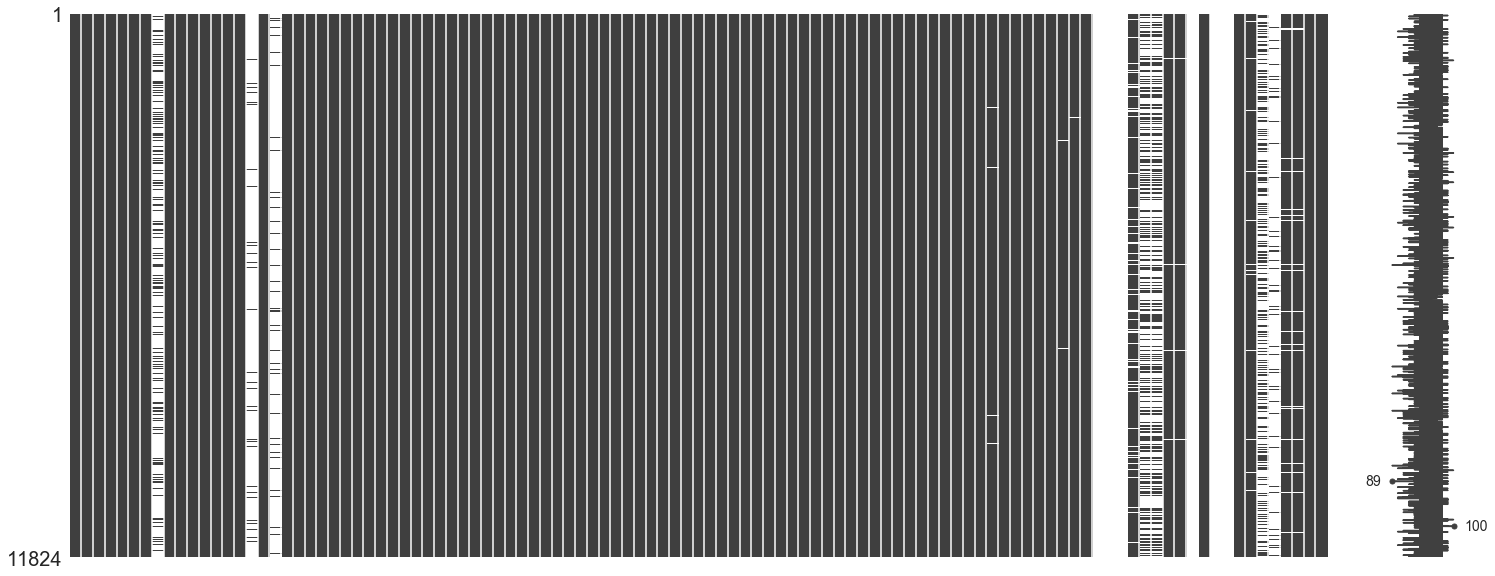

In [4]:
msgo.matrix(df_concat);

Hay muchas columnas con valores faltantes, las cuales podemos eliminar:

In [5]:
nicos.clean(df_concat)

Columnas a eliminar: ['rescode', 'zip', 'state', 'aptnum', 'compyear', 'linecm', 'othfeatr', 'comppct', 'premtype']


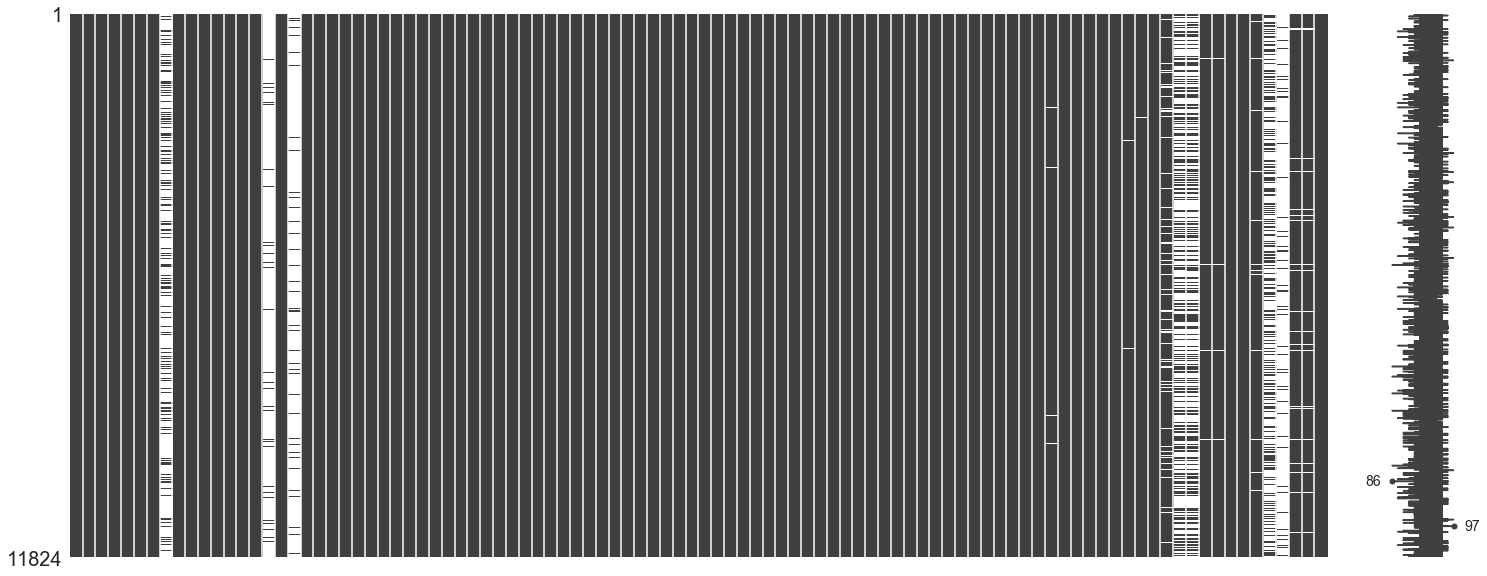

In [6]:
msgo.matrix(df_concat);

Hay varias columnas con muchos valores `na`. Esto lo solucionaremos en la etapa de preprocesamiento / feature engineering.

### Vector Objetivo

Los vector objetivo es la variable `arstmade` y `violence`. Este último si bien no existe como atributo único, se debe crear en base a los atributos cuyo prefijo corresponde a `pf_`, 

In [7]:
df_violence = df_concat.copy(deep=True)
serie_pf = []
for colname in df_concat.columns:
    if "pf_" in colname:
        df_violence[colname] = np.where(df_violence[colname] == 'YES', 1,0)
        serie_pf.append(colname)
df_violence["violence"] = df_violence.loc[:,serie_pf].sum(axis=1)
df_violence["violence"] = np.where(df_violence["violence"]>0,'YES','NO')
df_violence.drop(columns=serie_pf, axis=1, inplace=True)

Revisamos las variables objetivos y evaluamos cuan desbalanceadas se encuentran

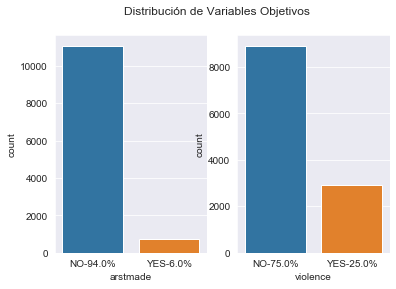

In [8]:
plt.subplot(1,2,1)
fig = sns.countplot(df_concat.arstmade)
fig.set(xticklabels=[f'{i}-{100*np.round(j,2)}%' for i, j in dict(df_concat.arstmade.value_counts(normalize=True)).items()])
plt.subplot(1,2,2)
fig = sns.countplot(df_violence.violence)
fig.set(xticklabels=[f'{i}-{100*np.round(j,2)}%' for i, j in dict(df_violence.violence.value_counts(normalize=True)).items()])
plt.suptitle('Distribución de Variables Objetivos');

Podemos ver que la clases están desbalanceadas, una pequeña porción (6%) de las observaciones terminaron en arrestros, asi como un 25% involucró violencia.
¿Cómo anda cada dataset por separado?

In [9]:
print('2009-arstmade:', 100 * df_2009.arstmade.value_counts(normalize=True)['YES'])
print('2010-arstmade:', 100 * df_2010.arstmade.value_counts(normalize=True)['YES'])
print('\n')
print('2009-violence:', 100 * df_violence[df_violence.year==2009].violence.value_counts(normalize=True)['YES'])
print('2010-violence:', 100 * df_violence[df_violence.year==2010].violence.value_counts(normalize=True)['YES'])

2009-arstmade: 5.987611837577425
2010-arstmade: 6.636726546906188


2009-violence: 25.0
2010-violence: 24.184963406520293


Hay similitud en las proporciones.

### Atributos

A continuación veremos la distirbución de cada atributo condicional a los vectores objetivos:

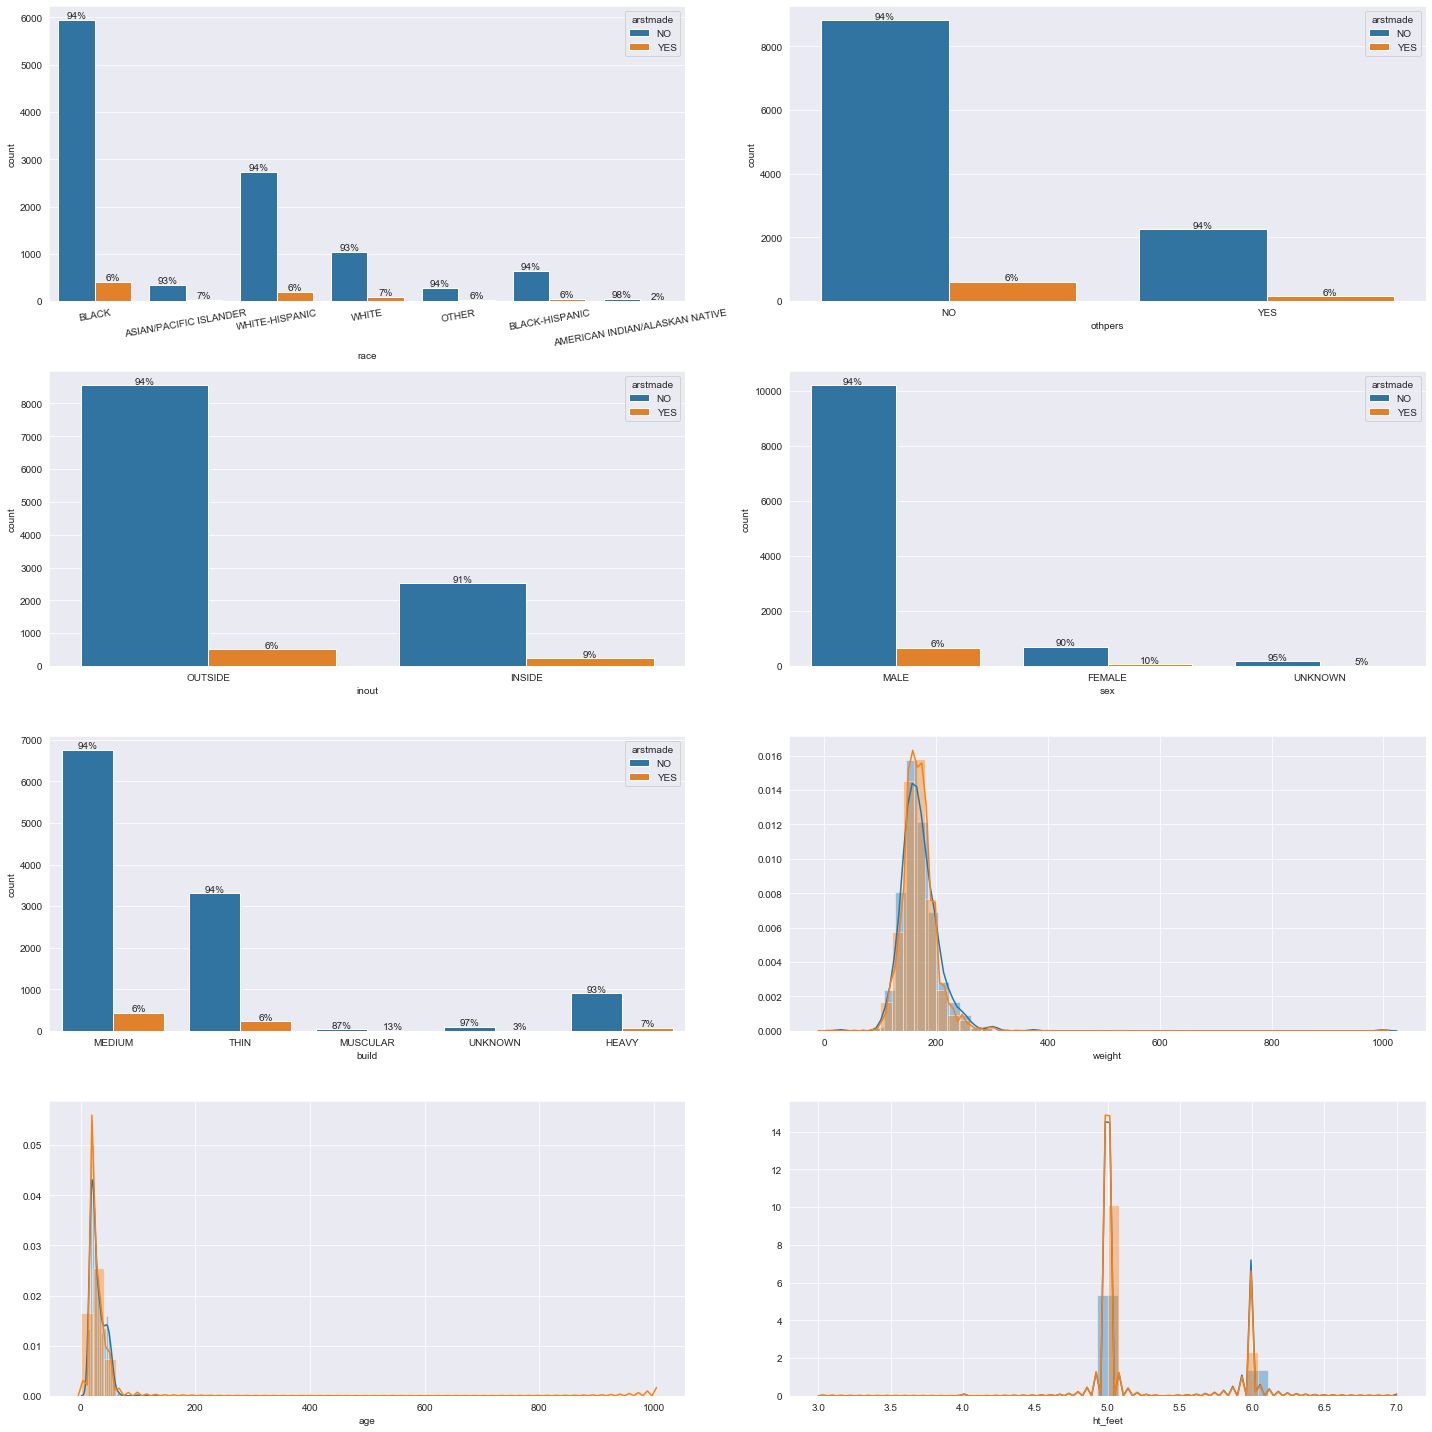

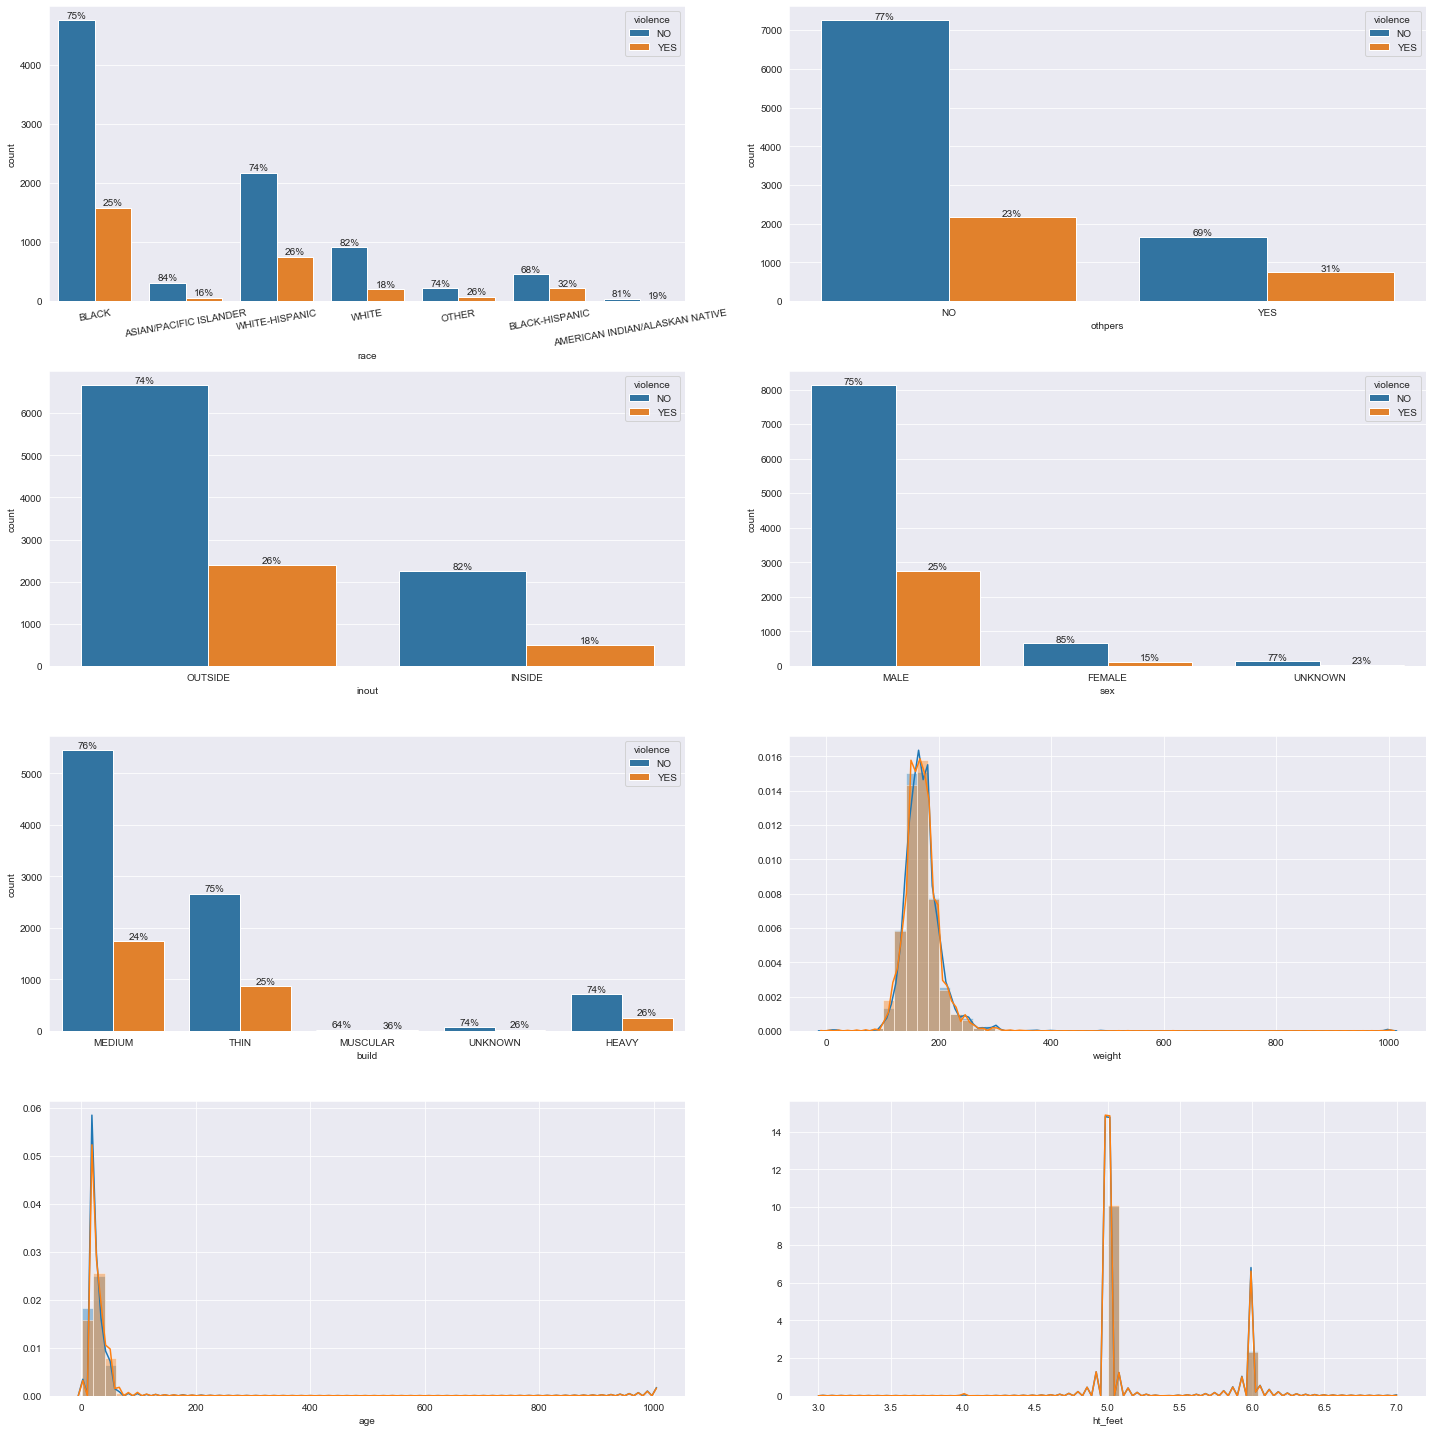

In [10]:
nicos.draw(features=['race', 'othpers', 'inout', 'sex', 'build', 'weight', 'age', 'ht_feet'], objetive='arstmade', df=df_concat, title='Arresto')
nicos.draw(features=['race', 'othpers', 'inout', 'sex', 'build', 'weight', 'age', 'ht_feet'], objetive='violence', df=df_violence, title='Violencia')


#### Características sospechoso vs Arresto:

* La porción de arrestros concretados entre las distintas razas de individuos es parecida, exceptuando a los `AMERICAN INDIAN/ALASKAN NATIVE` cuya fracción de arrestados es de 2%.
* No se ve diferencia en la porción de personas arrestadas cuando habían otras personas sospechosas y detenidas.
* Hay una diferencia de 3% de arrestros realizados, favoreciendo a las detenciones que fueron al interior.
* La porción de hombres que fueron arrestados es un 3% mayor a las mujeres.
* Se ve diferencias entre los arrestros de los distintos tipos de musculatura. Hay una leve diferencia entre los distintos tipos de musculatura. En particular, `build=MUSCULAR` es el grupo donde hay una mayor porción de arrestados, superando en un 6% (el doble) que el resto de categorías.
* El peso, la edad y la altura no presentan diferencias

#### Características sospechoso vs Violencia:

* Tiene un comportamiento similar a arresto con la diferencia que si presenta diferencias en raza y others

#### Vectores objetivo vs Circunstancias adicionales (`ac_`)

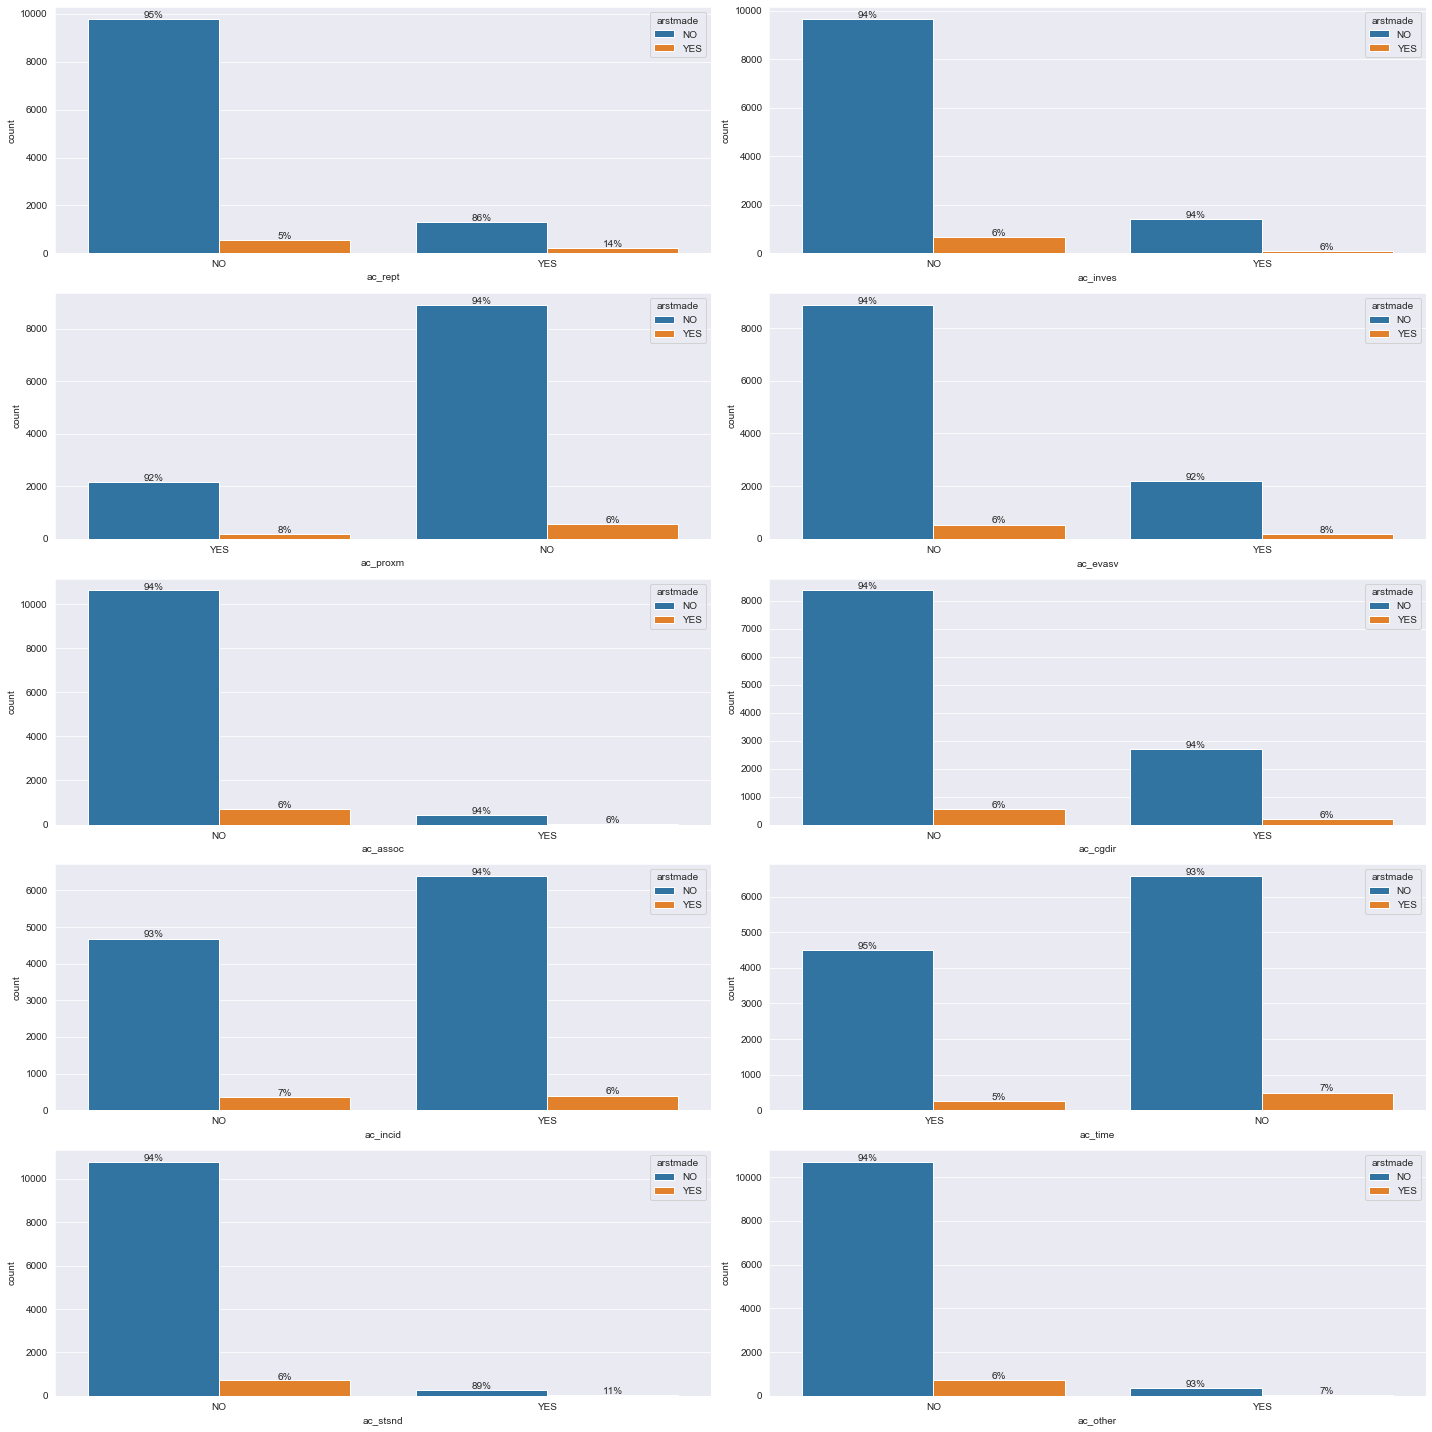

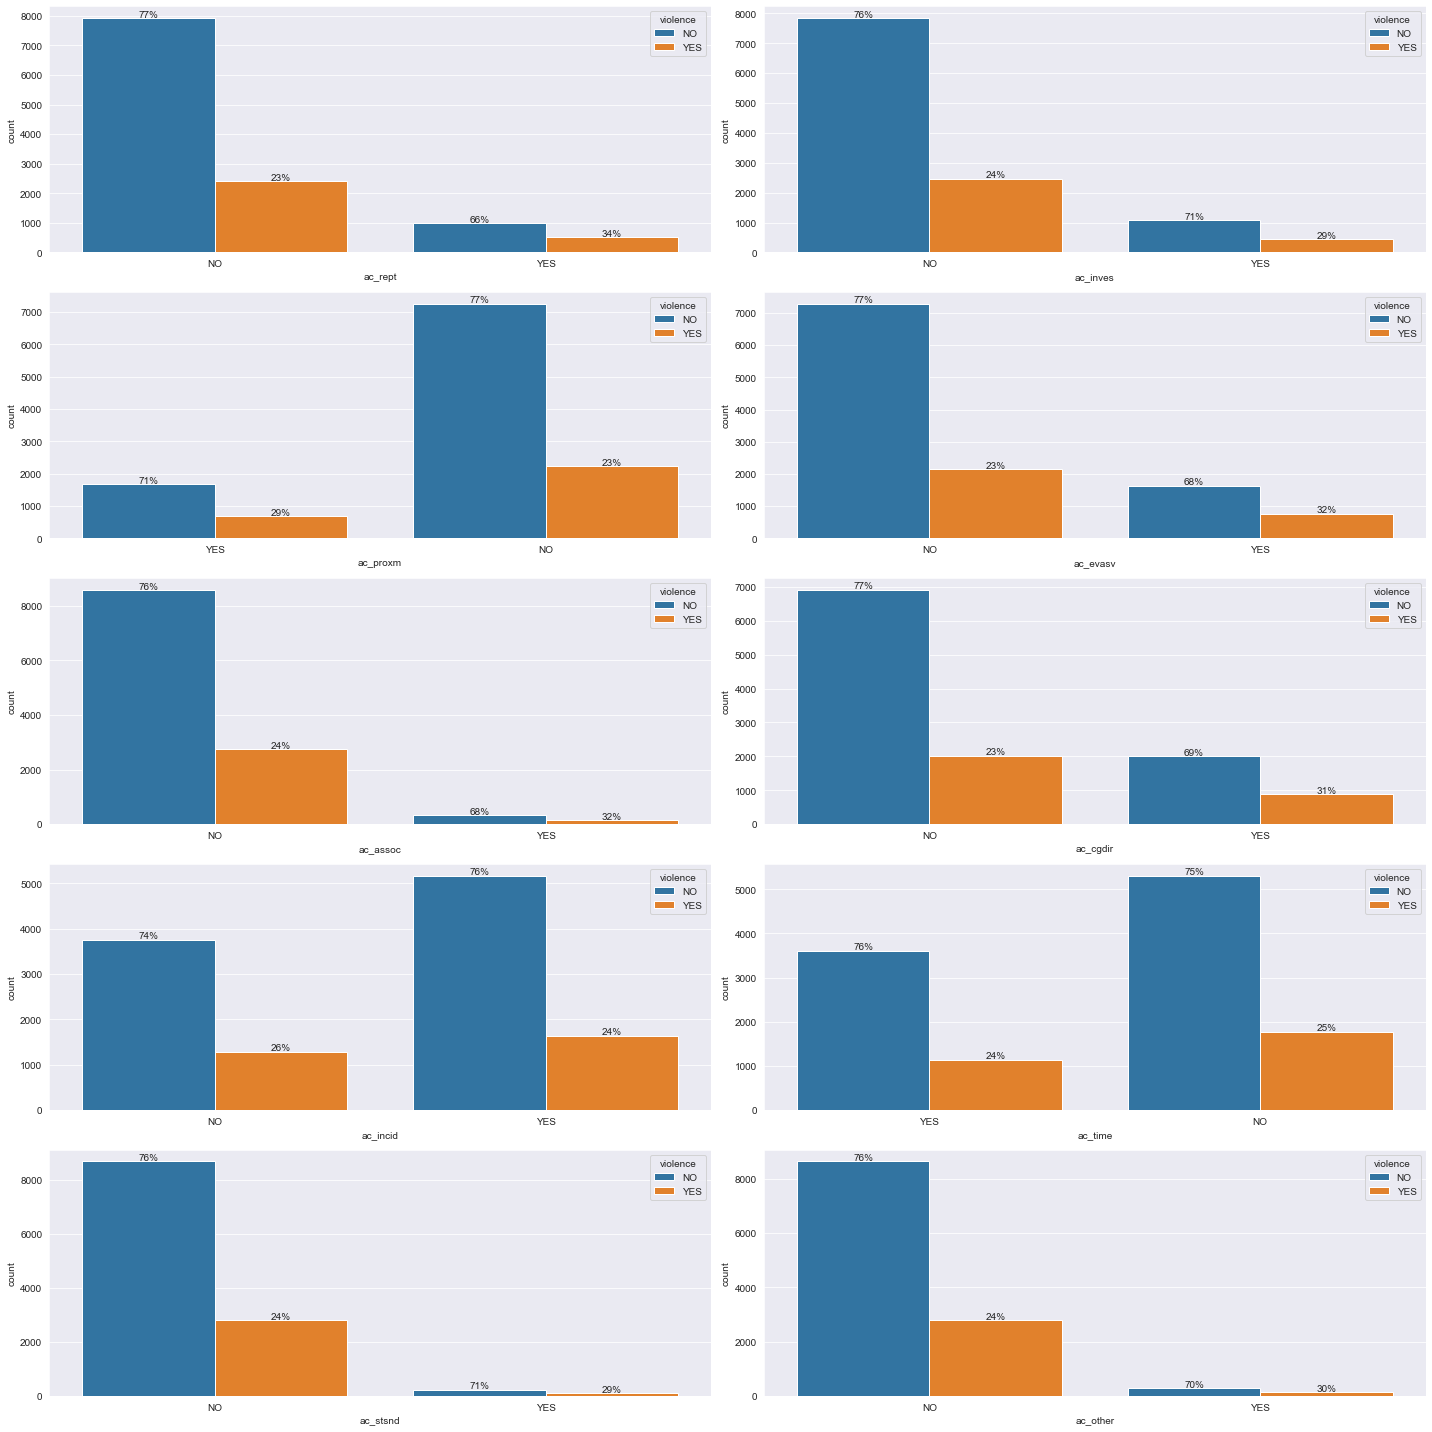

In [11]:
nicos.draw(features=[col for col in filter(lambda col: col.startswith('ac_'), df_concat.columns)], objetive='arstmade',df=df_concat)
nicos.draw(features=[col for col in filter(lambda col: col.startswith('ac_'), df_concat.columns)], objetive='violence',df=df_violence)

Para las variables que parten con `ac_`, sobre información adicional, podemos ver que en las variables `ac_rept`, `ac_proxm`, `ac_stsnd`, `ac_evasv` hay diferencia entre los arrestros realizados y los que no. Hay mayor proporción de arrestos en los siguientes casos:

- Observaciones donde hubo reporte de víctima tienen una mayor porción de arrestos (`ac_rept`)
- Proximidad a la escena de ofensa (`ac_proxm`)
- Señales o sonidos de actividad criminal (`ac_stsnd`)
- Respuestas evasivas a preguntas (`ac_evasv`)

Para el caso de violencia, tiene un comportamiento similar a arresto.

#### Vectores Objetivo y Razones de la sospecha (`cs_`)

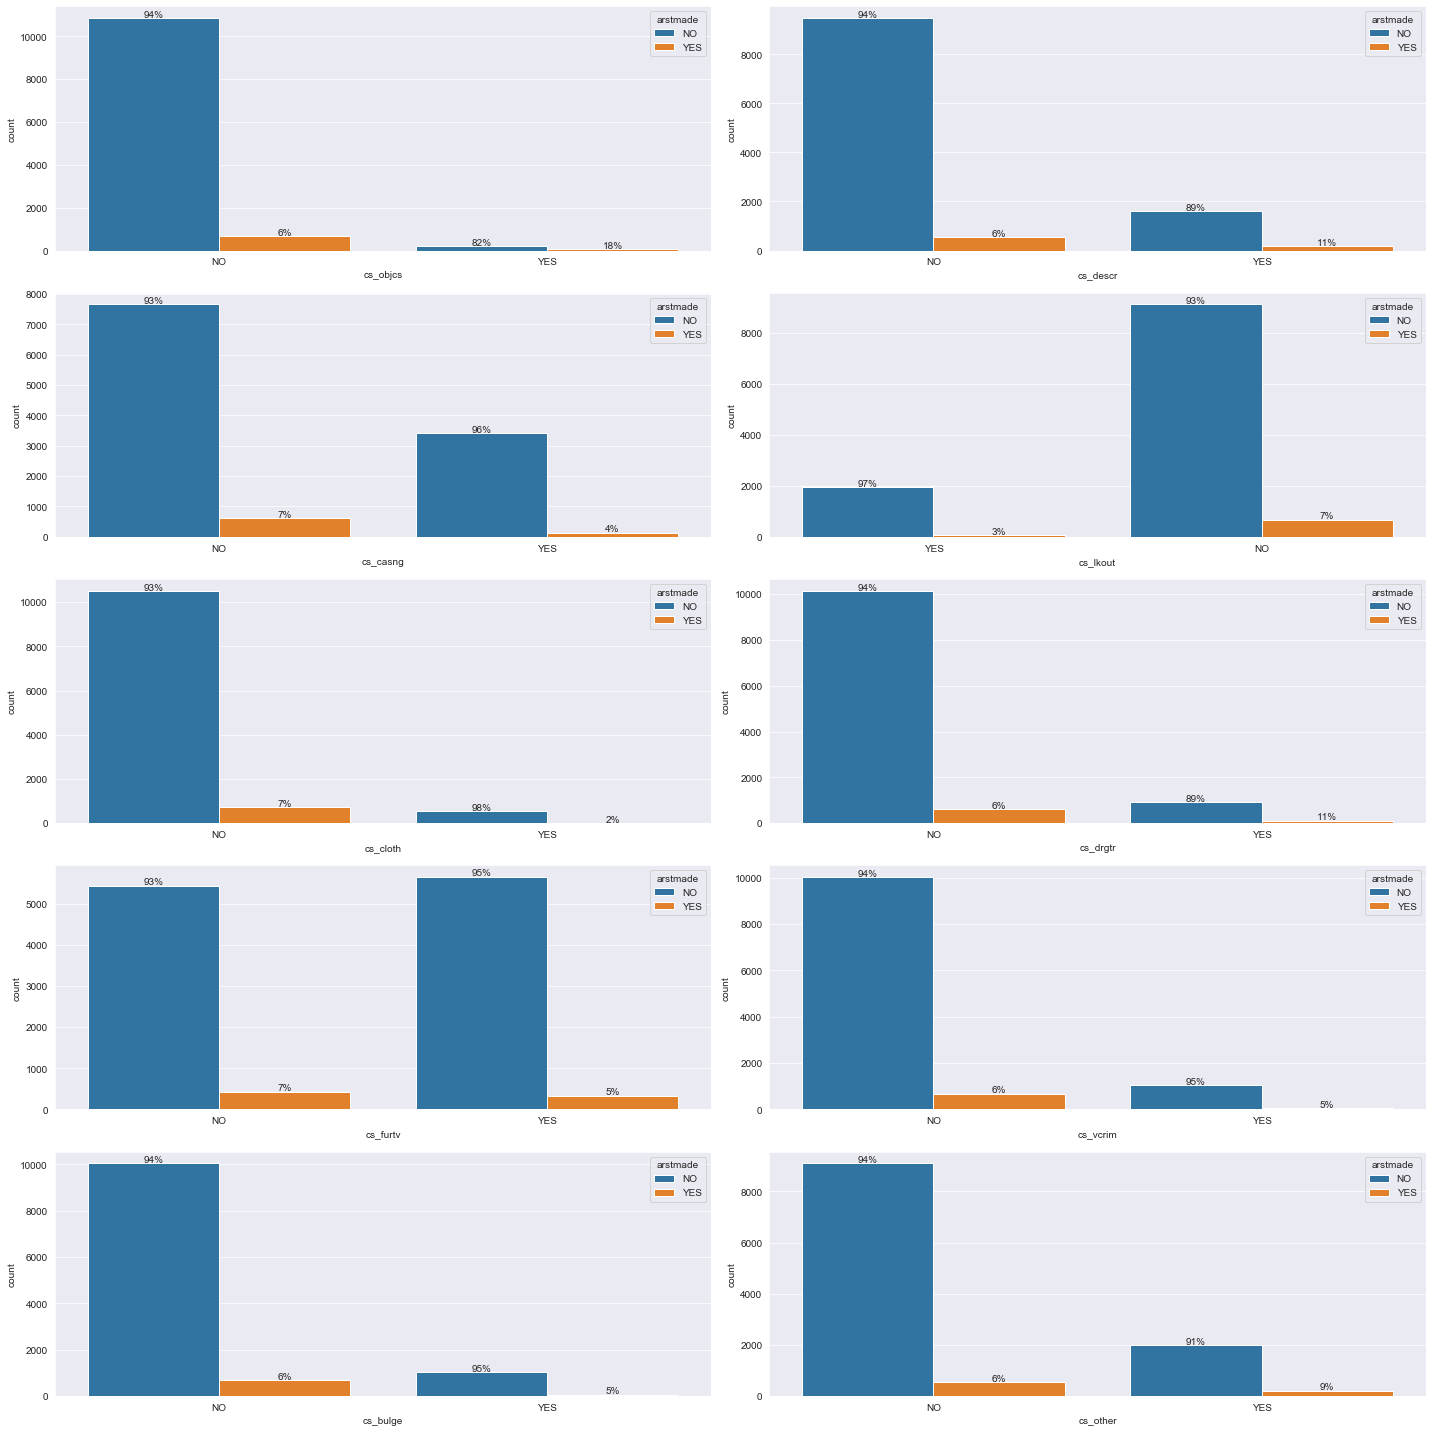

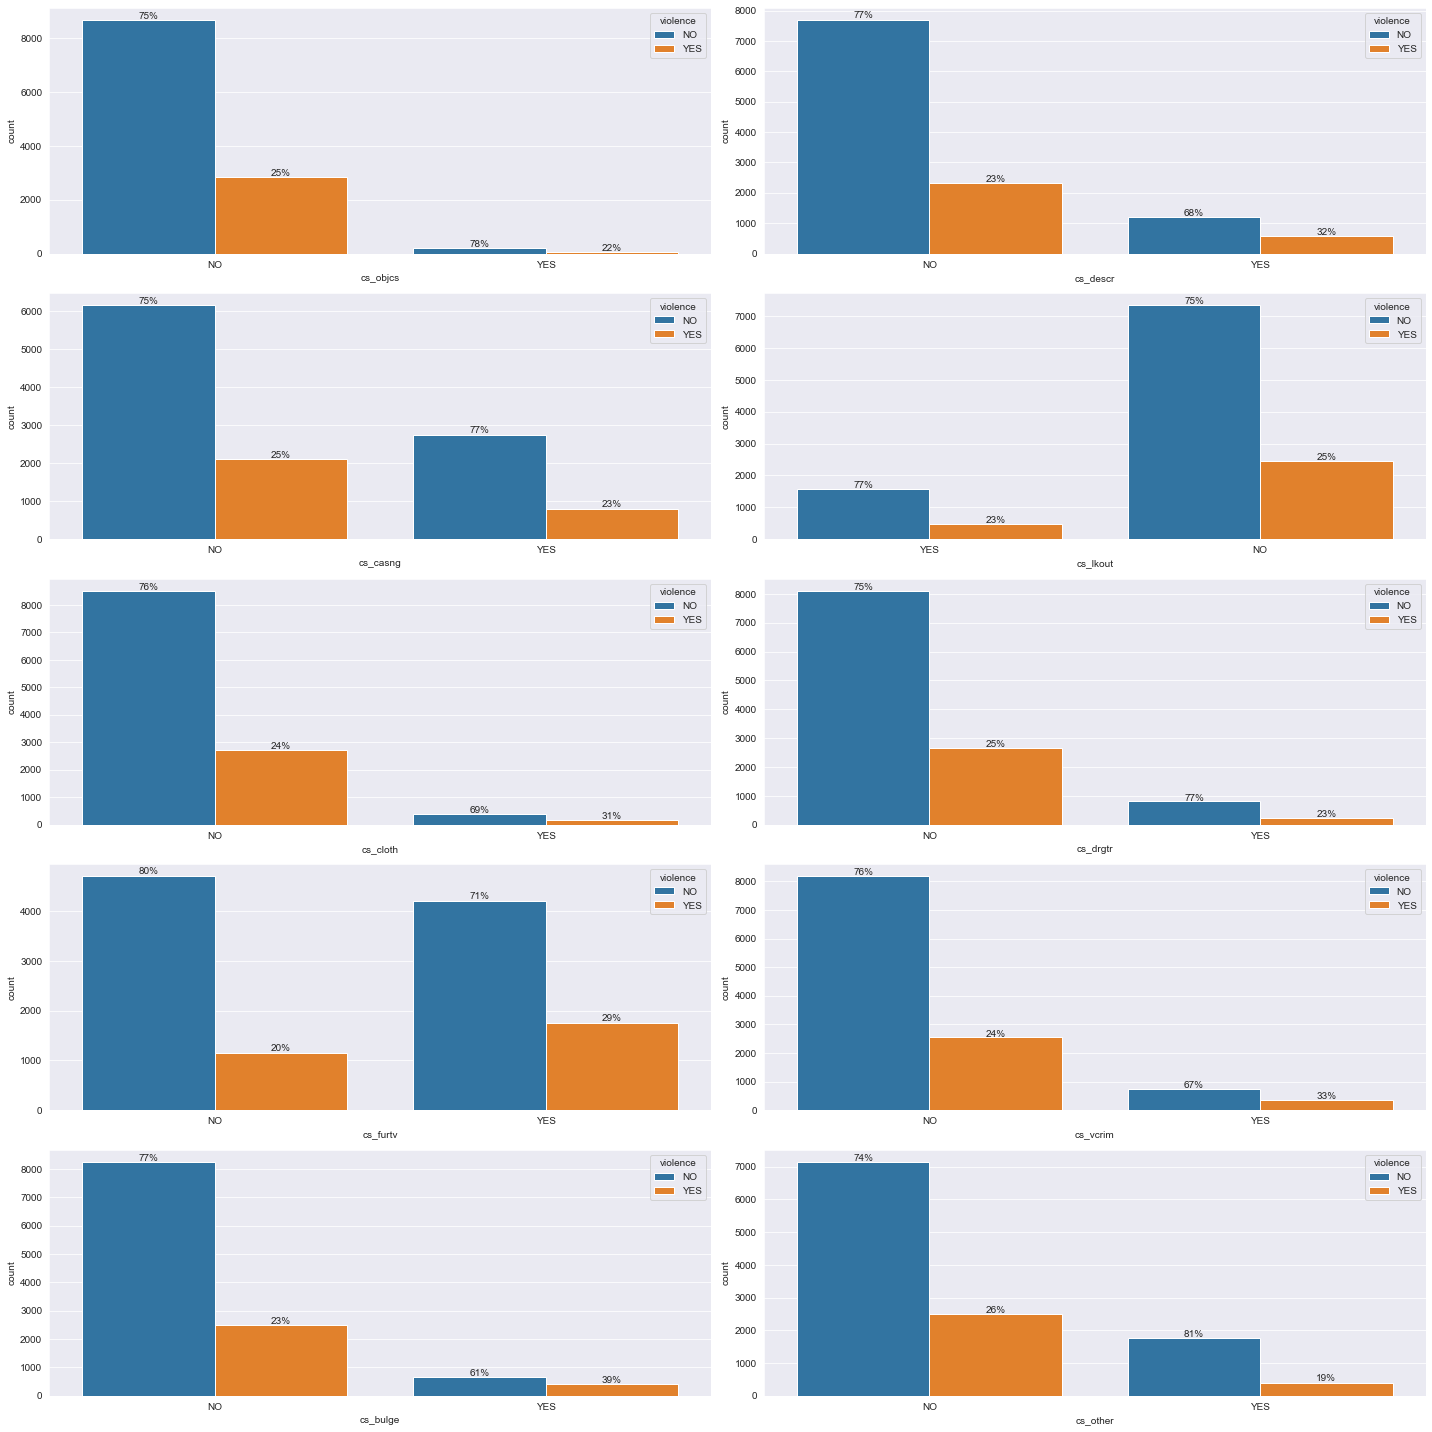

In [12]:
nicos.draw(features=[col for col in filter(lambda col: col.startswith('cs_'), df_concat.columns)], objetive='arstmade',df=df_concat)
nicos.draw(features=[col for col in filter(lambda col: col.startswith('cs_'), df_concat.columns)], objetive='violence',df=df_violence)

En las variables `cs_objcs`, `cs_descr`, `cs_drgtr`, `cs_other` hay una mayor proporción de arrestros (relativamente significativa):

- `cs_objcs`: individuo tenía un objetivo sospechoso.
- `cs_descr`: individuo concordaba con una descripción.
- `cs_drgtr`: acciones indicaban transacción de drogas.
- `cs_other`: otras razones.

En las variables `cs_casng`, `cs_lkout` y `cs_cloth` hay una menor proporción de arrestros (relativamente significativa):

- `cs_casng`: cubriendo una víctima o ubicación
- `cs_lkout`: ?
- `cs_cloth`: sospechoso actuando como un observador

Para el caso de violencia, en esta categoría presenta resultados menos desbalanceados que en el caso de arresto.

#### Vectores Objetivo vs Variables binarias (`rf_`, `pf_`, `ac_`, `cs_`, `sb_`)

A continuación se muestran las variables donde hay una diferencia significativa entre la proporción de arrestos:

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


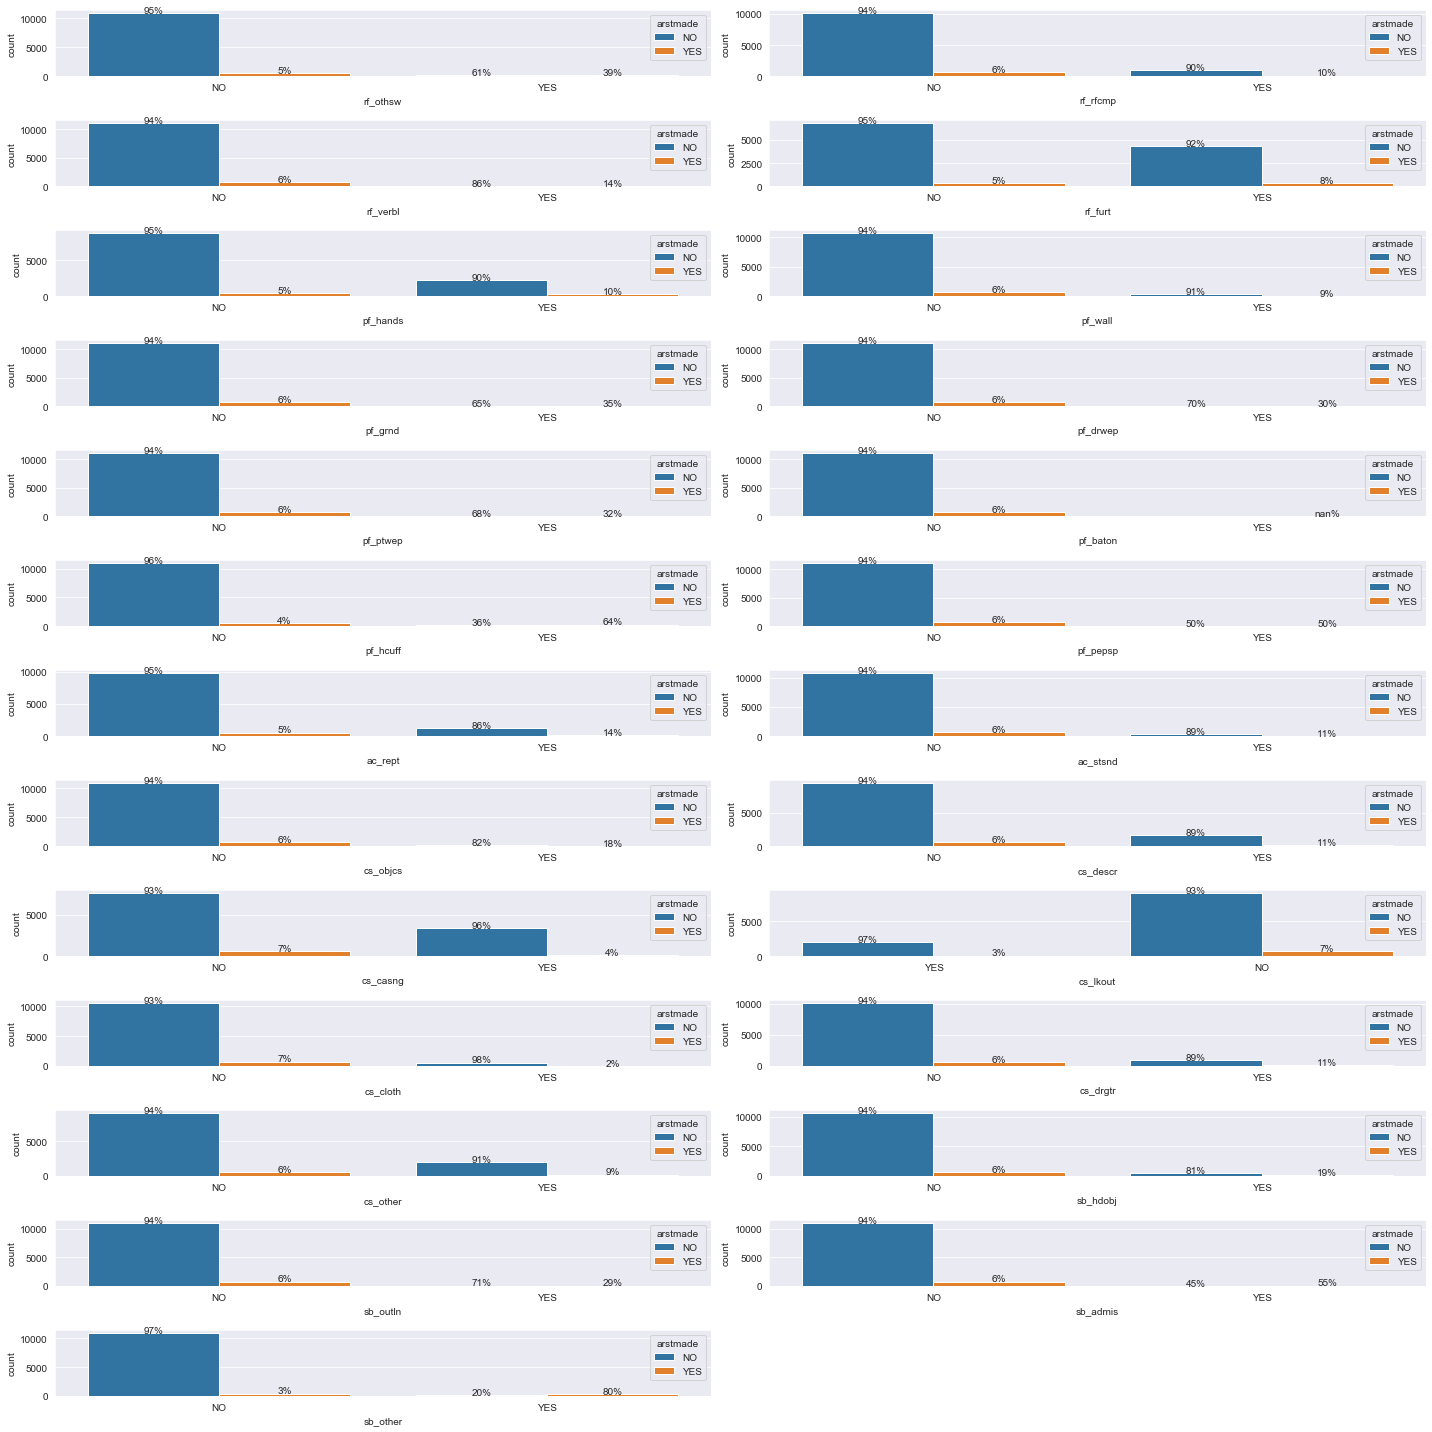

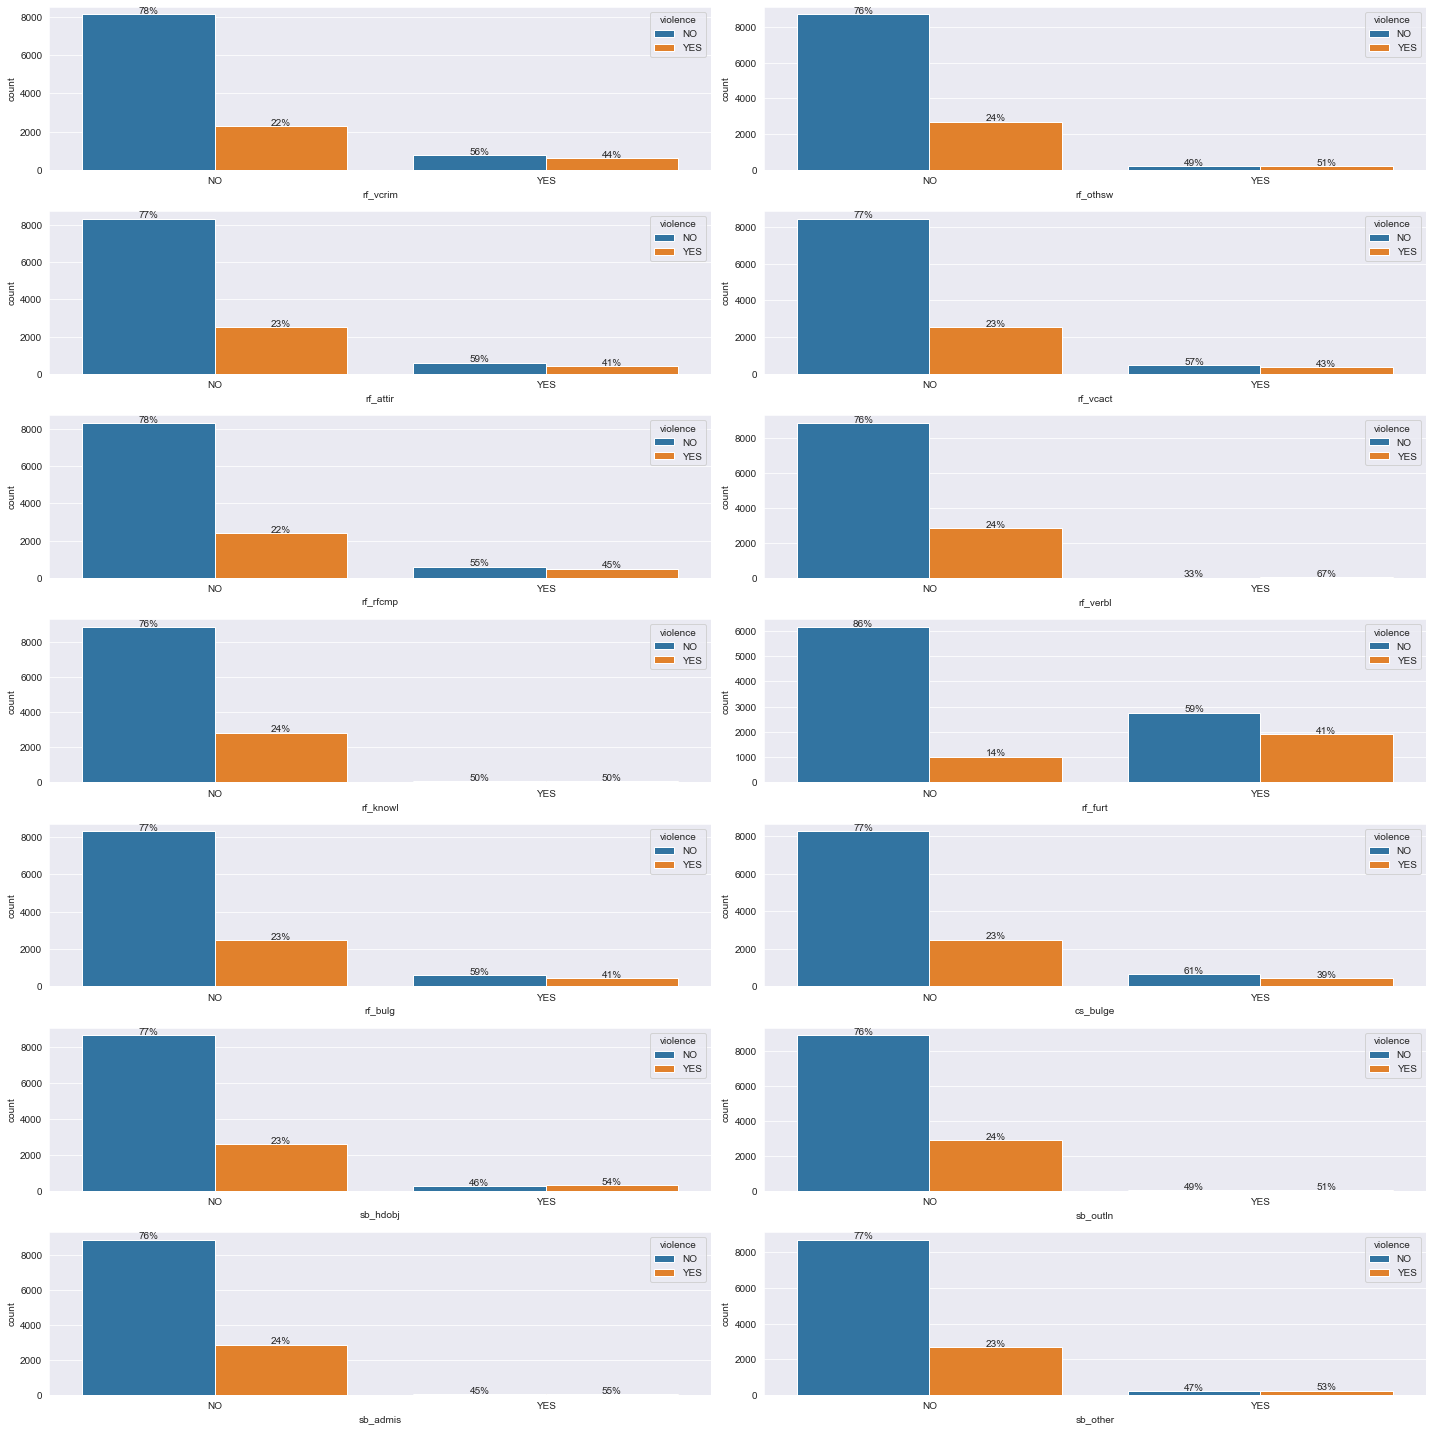

In [13]:
prefixes = ['rf_', 'pf_', 'ac_', 'cs_', 'sb_']
def representative_features(df, objetive):
    representative_features = []
    for prefix in prefixes:
        for col in filter(lambda col: col.startswith(prefix), df.columns):
            counts_yes = df[df[col] == 'YES'][objetive].value_counts(normalize=True)
            counts_no = df[df[col] == 'NO'][objetive].value_counts(normalize=True)
            max_count = max(counts_yes['YES'], counts_no['YES'])
            min_count = min(counts_yes['YES'], counts_no['YES'])
            diff = max_count / min_count
            if diff > 1.5:
                representative_features.append(col)
    nicos.draw(features=representative_features, objetive=objetive,df=df)
representative_features(df_concat, 'arstmade')
representative_features(df_violence, 'violence')

Al igual que en la agrupación anterior, `violence` tiene una distribución de clases menos desbalanceada que arrresto.

#### Relación entre coordenadas, sector y ciudad

El gráfico que sigue, muestra:
1. la relación que hay entre coordenadas y sector
2. la relación que hay entre coordenadas y city
3. de los lugares donde hubo procedmientos, cuales terminaron con arresto 

(-0.5, 578.5, 573.5, -0.5)

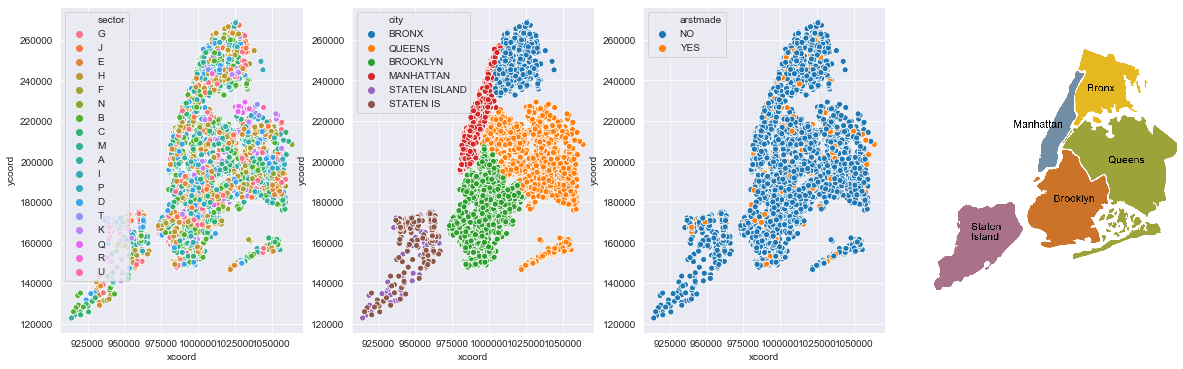

In [14]:
plt.figure(figsize=(20,6))
plt.subplot(1,4,1)
sns.scatterplot(x="xcoord", y="ycoord", data=df_concat, hue='sector')
plt.subplot(1,4,2)
sns.scatterplot(x="xcoord", y="ycoord", data=df_concat, hue='city')
plt.subplot(1,4,3)
sns.scatterplot(x="xcoord", y="ycoord", data=df_concat, hue='arstmade')
plt.subplot(1,4,4)
fig = plt.imread('data/new-york-five-boroughs-map.gif')
plt.imshow(fig)
plt.axis('off')

Aquí podemos ver que `STATEN ISLAND` es lo mismo que `STATEN IS`, por lo que podemos recodificar este valor:

In [15]:
df_concat['city'] = df_concat['city'].replace('STATEN IS', 'STATEN ISLAND')

#### Correlaciones

Las gráficas que siguen, evalúan la correlacción que existe entre las variables, luego del proceso de dummification de las variables categóricas. Para el análisis se analiza  por grupos: 
* pf
* rf
* cs
* ac
* other
* geografic

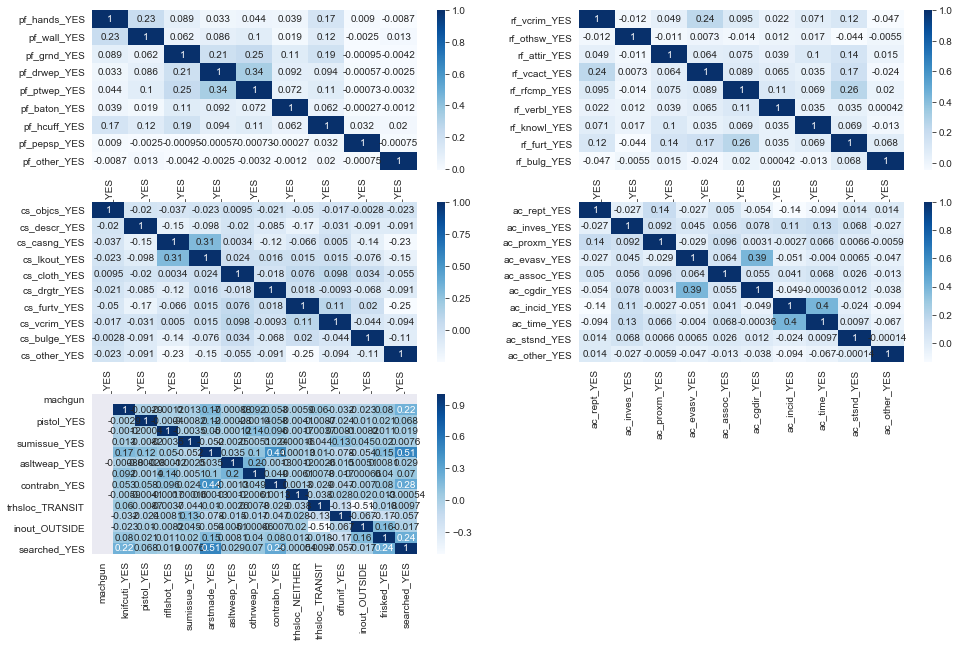

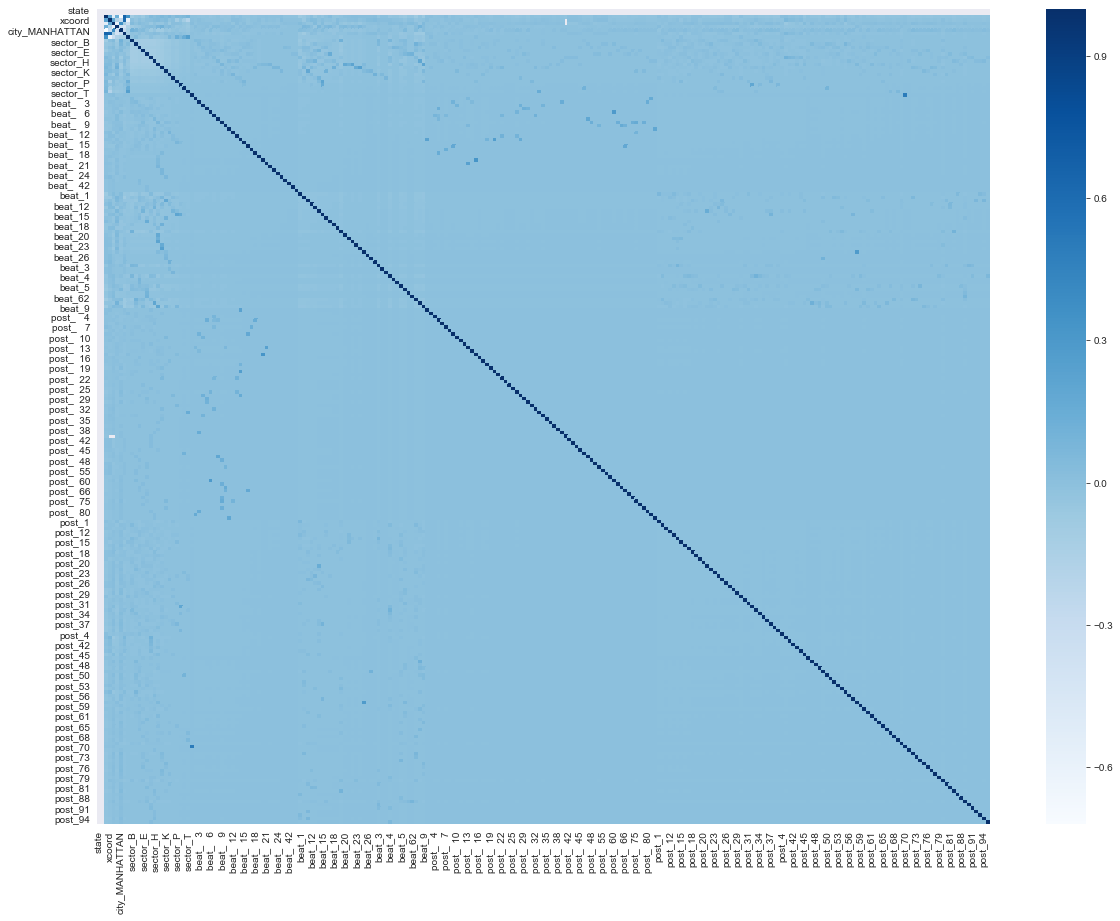

In [16]:
rows = df_concat.shape[0]
df_edit = df_concat.dropna(axis = 1,thresh = int(rows*0.80)).dropna(axis = 0)

plt.figure(figsize=(16,10))
pf_df = df_concat.select(lambda col: col.startswith('pf'), axis=1)
pf_df = pd.get_dummies(pf_df, drop_first=True)
rf_df = df_concat.select(lambda col: col.startswith('rf'), axis=1)
rf_df = pd.get_dummies(rf_df, drop_first=True)
cs_df = df_concat.select(lambda col: col.startswith('cs'), axis=1)
cs_df = pd.get_dummies(cs_df, drop_first=True)
ac_df = df_concat.select(lambda col: col.startswith('ac'), axis=1)
ac_df = pd.get_dummies(ac_df, drop_first=True)
colums = ['knifcuti', 'machgun', 'pistol', 'riflshot', 'sumissue', 'arstmade', 'asltweap', 'othrweap', 'contrabn', 'trhsloc', 'offunif', 'inout', 'frisked', 'searched']
was_df = df_concat.loc[:,colums]
was_df = pd.get_dummies(was_df, drop_first=True)

plt.subplot(3,2,1)
sns.heatmap(pf_df.corr(), annot=True, cmap='Blues')
plt.subplot(3,2,2)
sns.heatmap(rf_df.corr(), annot=True, cmap='Blues')
plt.subplot(3,2,3)
sns.heatmap(cs_df.corr(), annot=True, cmap='Blues')
plt.subplot(3,2,4)
sns.heatmap(ac_df.corr(), annot=True, cmap='Blues')
plt.subplot(3,2,5)
sns.heatmap(was_df.corr(), annot=True, cmap='Blues')

plt.figure(figsize=(20,15))
loc_columns = ['city', 'state', 'zip', 'addrpct', 'sector', 'beat', 'post', 'xcoord', 'ycoord']
loc_df = df_concat.loc[:,loc_columns]
loc_df = pd.get_dummies(loc_df, drop_first=True)
sns.heatmap(loc_df.corr(), cmap='Blues')

Por grupo de anális, se evidencia atributos con correlación mayor: 
* pf: sin evidencia
* rf: sin evidencia
* cs: sin evidencia
* ac: sin evidencia
* other:  th_sloc_p con inout_O
* geografic: 
    * se evidencia relación entre city, ycoord y addrpct

## Preprocesamiento y Feature Engineering

### Estrategia de preprocesamiento y Feature Engineering

#### Edad

- Nos basaremos en la variable `dob` para generar la edad de cada individuo.
- Si el valor no es válido (no dentro del rango de 18 y 100), utilizaremos la media para rellenar el valor.

#### Fechas

- Pasaremos la columna `datestop` a mes (categórica).
- Pasaremos la columna `timestop` a `morning`, `afternoon` y `evening` (categórica).

#### Estatura

- Utilizaremos la variable `ht_feet` y `ht_inch` para calcular la altura en metros

#### Otros

- `premname` y `detailcm` son nominales, pero tienen categorías con muy poca cantidad de datos. Reemplazaremos las que tienen poca cantidad por una nueva categoría llamada `OTHER`

#### Variables a eliminar

- Las variables `repcmd` y `revcmd` tienen que ver con con un número incremental de reporte que llenan los oficiales (parte en 1, termina en 999 y luego vuelve a 1), por lo que no es algo que prediga arrestos. Algo parecido sucede con `ser_num`, el cual es un número de serie ([fuente](https://www.usccr.gov/pubs/nypolice/ch5.htm))
- La variable `linecm` tiene 1 valor `NaN` y el resto son todos `1.0` (únicos)
- La variable `crimsusp`, `sumoffen`, `arstoffn` tienen datos muy suicios y no estandarizados (nominal ingresado a mano).
- Las variables `datestop`, `timestop`, `dob`, `ht_feet`, `ht_inch`, `weight` fueron reprocesadads.
- La variable `crossst`, `stinter`, `post` está contenida en las coordenadas.

#### Luego de hacer todos estos cambios:

- Aplicaremos `get_dummies` para transformar todas las variables categóricas en numéricas.
- Utilizaremos `standarScaler` para estandarizar todos los valores.

### Preprocesamiento

In [17]:
df_arrest = nicos.preprocess(df_edit)
df_violence = nicos.preprocess(df_violence).dropna(axis = 1, thresh = int(df_violence.shape[0] * 0.80)).dropna(axis = 0)

### Convertimos variables categóricas en dummy

In [18]:
df_final = pd.get_dummies(df_arrest, drop_first=True)
df_final.shape

(10035, 228)

In [19]:
df_violence = pd.get_dummies(df_violence, drop_first=True)
df_violence.shape

(10037, 224)

### Estandarizamos

In [20]:
scaler = StandardScaler()

for col in df_final:
    if col != 'year' and col != 'arstmade_YES':
        df_final[col] = scaler.fit_transform(df_final[col].values.reshape(-1, 1))
        
for col in df_violence:
    if col != 'year' and col != 'violence_YES':
        df_violence[col] = scaler.fit_transform(df_violence[col].values.reshape(-1, 1))

In [21]:
# pd.Series(np.where(df_violence['arstoffn'].isna(), 'NO', 'YES')).value_counts()

### Vectores Objetivo

Los vectores objetivos son:

1. `arstmade`, el cual quedó como `arstmade_YES` al dummificar (variable binaria, 1 si la observación terminó en arrestro, 0 en caso contrario).
2. `violence`, el cual quedó como `violence_YES` al dumificar (variable binaria, 1 si la observación terminó en violencia).

### Visualización post preprocesamiento

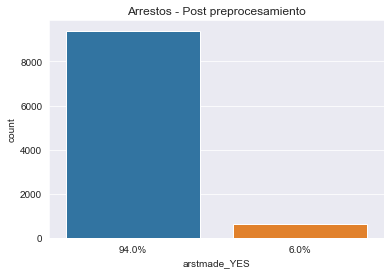

In [22]:
fig = sns.countplot(df_final.arstmade_YES)
fig.set(xticklabels=[f'{100*np.round(j, 2)}%' for i, j in dict(df_final.arstmade_YES.value_counts(normalize=True)).items()])
plt.title('Arrestos - Post preprocesamiento');

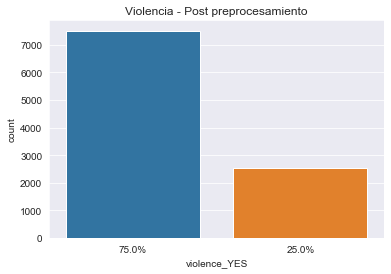

In [23]:
fig = sns.countplot(df_violence.violence_YES)
fig.set(xticklabels=[f'{100*np.round(j, 2)}%' for i, j in dict(df_violence.violence_YES.value_counts(normalize=True)).items()])
plt.title('Violencia - Post preprocesamiento');

## Modelos para predecir arrestos

Primero seleccionaremos nuestros conjuntos de entramiento y de validación:

In [24]:
# Generación Xtrain, Ytrain, Xtest, Ytest para arresto
df_final_2009 = df_final[df_final.year == 2009].drop(columns='year')
df_final_2010 = df_final[df_final.year == 2010].drop(columns='year')

y_train = df_final_2009['arstmade_YES']
X_train = df_final_2009.drop(columns='arstmade_YES')

y_test = df_final_2010['arstmade_YES']
X_test = df_final_2010.drop(columns='arstmade_YES')

Evaluaremos 5 modelos para predecir los arrestos, entre ellos `RandomForest` para encontrar las features más importantes

#### Primer Modelo: NaiveBernoulli

In [25]:
model_nb = BernoulliNB()
model_nb.fit(X_train, y_train)
print(classification_report(y_test, model_nb.predict(X_test)))

              precision    recall  f1-score   support

           0       0.98      0.97      0.97      4720
           1       0.61      0.72      0.66       339

    accuracy                           0.95      5059
   macro avg       0.79      0.84      0.82      5059
weighted avg       0.95      0.95      0.95      5059



#### Segundo Modelo: Regresión Logística

In [26]:
model_lr = LogisticRegression(random_state=4092019)
model_lr.fit(X_train, y_train)
print(classification_report(y_test, model_lr.predict(X_test)))

              precision    recall  f1-score   support

           0       0.97      0.99      0.98      4720
           1       0.81      0.60      0.69       339

    accuracy                           0.96      5059
   macro avg       0.89      0.80      0.84      5059
weighted avg       0.96      0.96      0.96      5059



#### Tercer Modelo: Máquina de Soporte Vectorial

In [27]:
params = {
    "kernel": ["rbf"],
    "C": [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000],
    "gamma": [0.0000001, 0.0001, 0.001, 0.01, 0.1, 1, 10],
}

model_GS_SVM = GridSearchCV(SVC(random_state=4092019, probability=True), param_grid=params, cv=2, n_jobs=-1, refit=True)
model_GS_SVM.fit(X_train, y_train)
print(classification_report(y_test, model_GS_SVM.predict(X_test)))

              precision    recall  f1-score   support

           0       0.97      0.99      0.98      4720
           1       0.86      0.60      0.70       339

    accuracy                           0.97      5059
   macro avg       0.91      0.80      0.84      5059
weighted avg       0.96      0.97      0.96      5059



#### Cuarto Modelo: Random Forest

In [28]:
params = {
    "n_estimators": list(np.linspace(20, 1000, 50, dtype = "int")),
    "max_features": [None, "log2", "sqrt"]
}

rfc = RandomForestClassifier(
    oob_score = True,
    criterion = "gini",
    max_depth = 16,
    random_state = 4092019
)

model_GS_rf = GridSearchCV(rfc, param_grid = params, cv = 2, n_jobs=-1)

model_GS_rf.fit(X_train, y_train)

print(classification_report(y_test, model_GS_rf.predict(X_test)))

              precision    recall  f1-score   support

           0       0.97      0.99      0.98      4720
           1       0.82      0.63      0.72       339

    accuracy                           0.97      5059
   macro avg       0.90      0.81      0.85      5059
weighted avg       0.96      0.97      0.96      5059



#### Quinto Modelo: Ridge

In [29]:
parameters = {
    'alpha': [1e-3, 1e-2, 1e-1, 1],
    'normalize': [True, False],
}

model_GS_ridge = GridSearchCV(RidgeClassifier(random_state=4092019), param_grid=parameters, cv = 2, n_jobs=-1)

model_GS_ridge.fit(X_train, y_train)
print(classification_report(y_test, model_GS_ridge.predict(X_test)))

              precision    recall  f1-score   support

           0       0.97      0.99      0.98      4720
           1       0.85      0.57      0.68       339

    accuracy                           0.96      5059
   macro avg       0.91      0.78      0.83      5059
weighted avg       0.96      0.96      0.96      5059



### Arrestos: Elección de modelos

Para tener más información sobre cual modelo elegir, calcularemos el AUC score y además las curvas ROC de cada modelo:

#### AUC

In [30]:
roc_curves = {}

models = [
    ('Bernoulli', model_nb),
    ('LR', model_lr),
    ('SVM', model_GS_SVM),
    ('RF', model_GS_rf),
    ('Ridge', model_GS_ridge),
]

for i, (name, model) in enumerate(models):
    if name == 'Ridge': # https://stackoverflow.com/a/22587041
        d = model.decision_function(X_test)
        prob = np.exp(d) / np.sum(np.exp(d))
    else:
        prob = model.predict_proba(X_test)[:, 1]
    roc_curves[i] = roc_curve(y_test, prob)
    print(name, 'AUC:', roc_auc_score(y_test, prob))

Bernoulli AUC: 0.9223113844307785
LR AUC: 0.9115994200289985
SVM AUC: 0.9219132793360332
RF AUC: 0.9173741312934354
Ridge AUC: 0.9328633568321583


#### Curva ROC

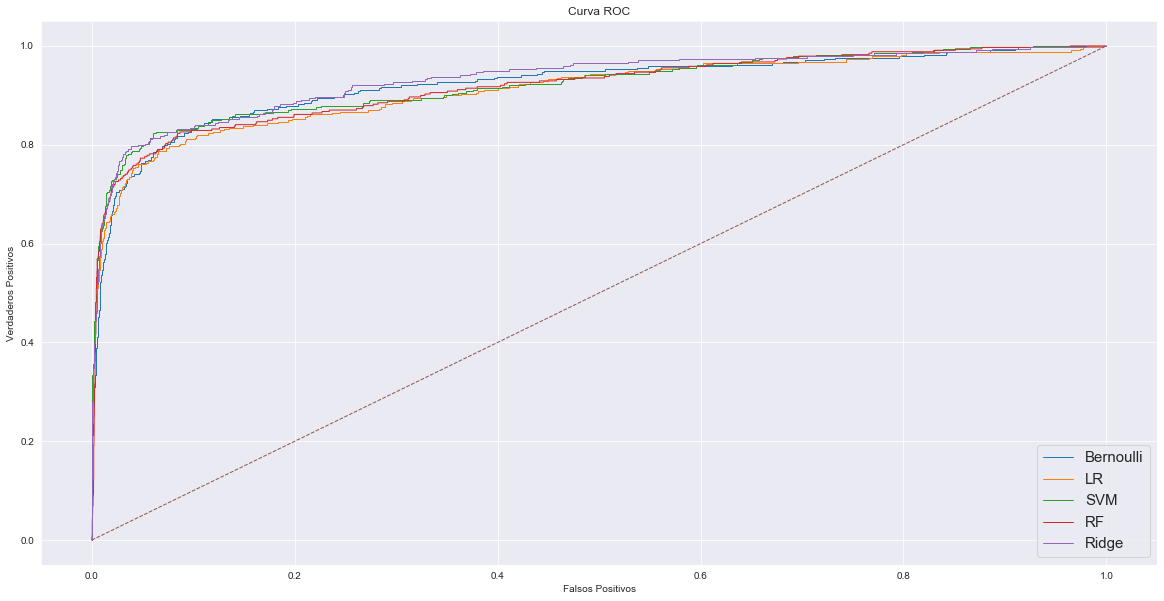

In [31]:
plt.figure(figsize=(20, 10))
plt.title('Curva ROC')

for i, (name, model) in enumerate(models):
    plt.plot(roc_curves[i][0], roc_curves[i][1], lw=1, label=name)

plt.plot([0, 1], ls="--", lw=1)
plt.ylabel('Verdaderos Positivos')
plt.legend(prop={'size': 15})
plt.xlabel('Falsos Positivos');

#### ¿Qué modelo se recomienda? (respuesta a 3.1)

Finalmente se recomienda utilizar el modelo en función de las dos discriminantes solicitadas: AUC y ACCURANCY, Se observó que los mejores resultados de AUC fueron para el modelo de SVM y Ridge, 92% y 93% respectivamente. Por tanto, se procedio a buscar el mejor resultado por acurrancy, en dicho caso se obtiene un 97% para el SVM, lo cual entrega un punto porcentual superior a Ridge. Como no había claridad en cual elegir, se observo la precisión, en donde el modelo SVM presentaba precisiones mejores en comparación a Ridge. Por tanto, se recomienda la utilización del MODELO SVM.

#### ¿Cuáles son los atributos más importantes? (respuesta a 3.2) 

En cuanto a la refinación de los atributos, se procedío a buscar los 30 mejores atributos por medio del modelo de RandomForest. Con la función `features_importance_`. Gracias a esto se entregan los mejores 30 mejores atributos segun importancia relativa.

In [32]:
def plot_importance(fit_model, feat_names, head = True, records = 30):
    tmp_importance = fit_model.feature_importances_
    
    importance_df = pd.DataFrame(tmp_importance, index=feat_names, columns=['value'])
    if head:
        importance_df = importance_df.sort_values(by='value', ascending=False).head(records)
        title = 'Mejores {} features'.format(records)
    else:
        importance_df = importance_df.sort_values(by='value', ascending=False).tail(records)
        title = 'Peores {} features'.format(records)
        
    plt.title(title)
    importance_df['value'].plot.barh(figsize=(10, 0.3 * records))
    return importance_df.index

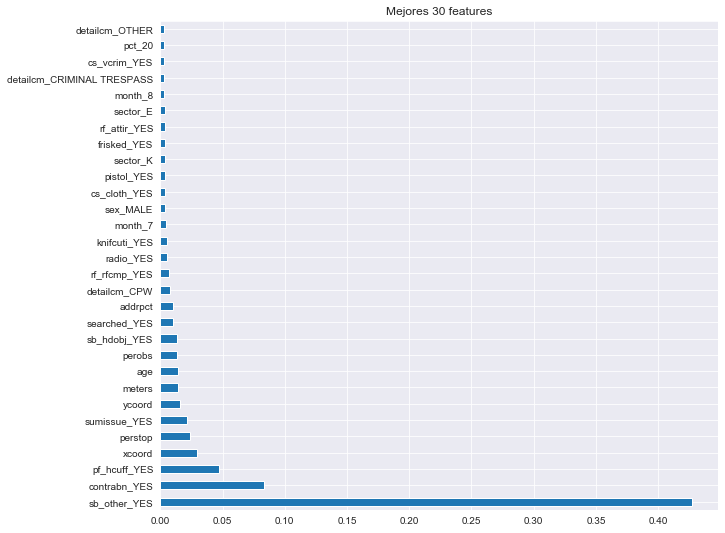

In [33]:
important_features = plot_importance(model_GS_rf.best_estimator_, X_train.columns)

#### Probabilidad de ser arrestado en uno de los cinco Barrios.

In [34]:
df_prob = df_arrest[df_arrest.year == 2010].drop(columns='year')
df_prob['pred'] = model_GS_SVM.predict(X_test)

In [35]:
df_prob_arrested = df_prob[df_prob['pred'] == 1]

In [36]:
100 * df_prob_arrested['city'].value_counts(normalize=True)

MANHATTAN        27.426160
QUEENS           24.894515
BROOKLYN         22.362869
BRONX            18.987342
STATEN ISLAND     6.329114
Name: city, dtype: float64

#### Probabilidad de ser arrestado en cada barrio condicionado al género

In [37]:
female = 100 * df_prob_arrested[df_prob_arrested['sex'] == 'FEMALE']['city'].value_counts(normalize=True)
male = 100 * df_prob_arrested[df_prob_arrested['sex'] == 'MALE']['city'].value_counts(normalize=True)
unknown = 100 * df_prob_arrested[df_prob_arrested['sex'] == 'UNKNOWN']['city'].value_counts(normalize=True)

Mujeres

In [38]:
female

BRONX        40.0
MANHATTAN    32.0
BROOKLYN     16.0
QUEENS       12.0
Name: city, dtype: float64

Hombres

In [39]:
male

MANHATTAN        27.403846
QUEENS           26.442308
BROOKLYN         22.596154
BRONX            16.346154
STATEN ISLAND     7.211538
Name: city, dtype: float64

No categorizados

In [40]:
unknown

BROOKLYN    50.0
BRONX       25.0
QUEENS      25.0
Name: city, dtype: float64

#### Probabilidad de ser arrestado en cada barrio condicionado a la raza

In [41]:
races = df_prob.race.unique()
traduction = {
    'BLACK': 'Afroamericanos',
    'WHITE-HISPANIC': 'Hispanos blancos',
    'WHITE': 'Blancos',
    'BLACK-HISPANIC': 'Hispano-afroamericanos',
    'ASIAN/PACIFIC ISLANDER': 'Asiáticos',
    'AMERICAN INDIAN/ALASKAN NATIVE': 'Nativos',
    'OTHER': 'Otros',
}

probs = {}

for race in races:
    counts = df_prob_arrested[df_prob_arrested['race'] == race]['city'].value_counts(normalize=True)
    probs[race] = round(100 * counts, 2)
    
for race in races:
    print(traduction[race] + ':')
    print(probs[race], '\n')

Blancos:
QUEENS           34.62
BROOKLYN         23.08
MANHATTAN        23.08
BRONX            11.54
STATEN ISLAND     7.69
Name: city, dtype: float64 

Afroamericanos:
MANHATTAN        29.13
BROOKLYN         25.98
BRONX            19.69
QUEENS           17.32
STATEN ISLAND     7.87
Name: city, dtype: float64 

Hispanos blancos:
QUEENS           32.14
MANHATTAN        25.00
BRONX            21.43
BROOKLYN         16.07
STATEN ISLAND     5.36
Name: city, dtype: float64 

Hispano-afroamericanos:
MANHATTAN    60.0
BROOKLYN     20.0
BRONX        10.0
QUEENS       10.0
Name: city, dtype: float64 

Otros:
BRONX        50.0
BROOKLYN     25.0
MANHATTAN    12.5
QUEENS       12.5
Name: city, dtype: float64 

Asiáticos:
QUEENS       87.5
MANHATTAN    12.5
Name: city, dtype: float64 

Nativos:
QUEENS      50.0
BROOKLYN    50.0
Name: city, dtype: float64 



#### CONCLUSIONES:

- Se observa una relación interesante en que la población nativa norteamericana se centre en los lugares más típicos de nueva york, como es el caso de Brooklyn y Queens.
- Para el caso de Asiaticos, también tienen sentido que este principalmente en Queens, ya que ahí se encuentran las principales comunidades de extrajeros.
- Según reportes, se observa que la mayor probabilidad de ser arrestado y ser mujer es en Bronx.
- Por otro lado, el barrio con mayor probabilidad de ser arestado es en Manhattan, lo que tiene sentido si lo relacionamos con el alto tráfico de turistas y/o centro financiero-comercial

## Modelos para violencia

In [42]:
# Generación Xtrain, Ytrain, Xtest, Ytest para violencia

df_final_2009 = df_violence[df_violence.year == 2009].drop(columns='year')
df_final_2010 = df_violence[df_violence.year == 2010].drop(columns='year')

y_train = df_final_2009['violence_YES']
X_train = df_final_2009.drop(columns='violence_YES')

y_test = df_final_2010['violence_YES']
X_test = df_final_2010.drop(columns='violence_YES')

### Primer Modelo: NaiveBernoulli

In [43]:
model_nb = BernoulliNB()
model_nb.fit(X_train, y_train)
print(classification_report(y_test, model_nb.predict(X_test)))

              precision    recall  f1-score   support

           0       0.87      0.75      0.81      3815
           1       0.46      0.66      0.54      1246

    accuracy                           0.73      5061
   macro avg       0.67      0.71      0.68      5061
weighted avg       0.77      0.73      0.74      5061



### Segundo Modelo: Regresión Logística

In [44]:
model_lr = LogisticRegression(random_state=4092019)
model_lr.fit(X_train, y_train)
print(classification_report(y_test, model_lr.predict(X_test)))

              precision    recall  f1-score   support

           0       0.83      0.85      0.84      3815
           1       0.51      0.47      0.49      1246

    accuracy                           0.76      5061
   macro avg       0.67      0.66      0.66      5061
weighted avg       0.75      0.76      0.75      5061



### Tercer modelo: SVM

In [45]:
params = {
    "kernel": ["rbf"],
    "C": [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000],
    "gamma": [0.0000001, 0.0001, 0.001, 0.01, 0.1, 1, 10],
}

model_GS_SVM = GridSearchCV(SVC(random_state=4092019, probability=True), param_grid=params, cv=2, n_jobs=-1, refit=True)
model_GS_SVM.fit(X_train, y_train)
print(classification_report(y_test, model_GS_SVM.predict(X_test)))

              precision    recall  f1-score   support

           0       0.82      0.90      0.86      3815
           1       0.56      0.40      0.47      1246

    accuracy                           0.78      5061
   macro avg       0.69      0.65      0.66      5061
weighted avg       0.76      0.78      0.76      5061



### Cuarto modelo: RandomForest

In [46]:
params = {
    "n_estimators": list(np.linspace(20, 1000, 50, dtype = "int")),
    "max_features": [None, "log2", "sqrt"]
}

rfc = RandomForestClassifier(
    oob_score = True,
    criterion = "gini",
    max_depth = 16,
    random_state = 4092019
)

model_GS_rf = GridSearchCV(rfc, param_grid = params, cv = 2, n_jobs=-1)

model_GS_rf.fit(X_train, y_train)

print(classification_report(y_test, model_GS_rf.predict(X_test)))

              precision    recall  f1-score   support

           0       0.81      0.93      0.86      3815
           1       0.59      0.32      0.41      1246

    accuracy                           0.78      5061
   macro avg       0.70      0.62      0.64      5061
weighted avg       0.75      0.78      0.75      5061



### Quinto modelo: Ridge

In [47]:
parameters = {
    'alpha': [1e-3, 1e-2, 1e-1, 1],
    'normalize': [True, False],
}

model_GS_ridge = GridSearchCV(RidgeClassifier(random_state=4092019), param_grid=parameters, cv = 20, n_jobs=-1)

model_GS_ridge.fit(X_train, y_train)
print(classification_report(y_test, model_GS_ridge.predict(X_test)))

              precision    recall  f1-score   support

           0       0.82      0.86      0.84      3815
           1       0.50      0.42      0.45      1246

    accuracy                           0.75      5061
   macro avg       0.66      0.64      0.65      5061
weighted avg       0.74      0.75      0.74      5061



### Violencia: Elección de mejor modelo

#### AUC

In [48]:
roc_curves = {}

models = [
    ('Bernoulli', model_nb),
    ('LR', model_lr),
    ('SVM', model_GS_SVM),
    ('RF', model_GS_rf),
    ('Ridge', model_GS_ridge),
]

for i, (name, model) in enumerate(models):
    if name == 'Ridge': # https://stackoverflow.com/a/22587041
        d = model.decision_function(X_test)
        prob = np.exp(d) / np.sum(np.exp(d))
    else:
        prob = model.predict_proba(X_test)[:, 1]
    roc_curves[i] = roc_curve(y_test, prob)
    print(name, 'AUC:', roc_auc_score(y_test, prob))

Bernoulli AUC: 0.79391268310231
LR AUC: 0.78785565973632
SVM AUC: 0.7978529459407718
RF AUC: 0.803190918672386
Ridge AUC: 0.7689097904907762


#### Curva ROC

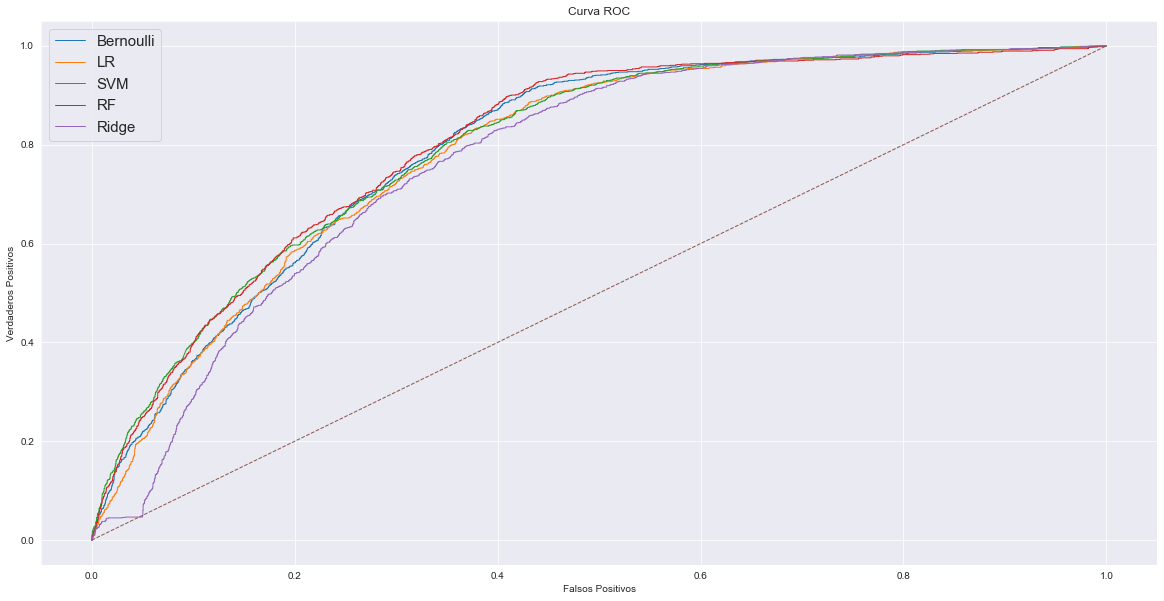

In [49]:
plt.figure(figsize=(20, 10))
plt.title('Curva ROC')

for i, (name, model) in enumerate(models):
    plt.plot(roc_curves[i][0], roc_curves[i][1], lw=1, label=name)

plt.plot([0, 1], ls="--", lw=1)
plt.ylabel('Verdaderos Positivos')
plt.legend(prop={'size': 15})
plt.xlabel('Falsos Positivos');

En base a los resultados, el modelo que mejor predice la violencia es `RandomForest` con un `AUC score` de 0.8 y con un `accuracy` de `0.78` y precision de `0.68`. Sin embargo, el `recall` es muy bajo, lo que significa que muchas detenciones que terminan en violencia no las está clasificando como tal.

El segundo mejor modelo es `Naive Bayes`, con un `AUC score` de 0.8, accuracy de `0.73`. Este es el modelo con mejor `f1-score` aunque su `precision` es bajo. Esto implica que es un modelo que piensa que muchas detenciones son arrestros, incluso algunas que no lo son.

Entonces la elección de modelos son: `RandomForest` y `Naive Bayes`.

En el caso de `RandomForest`, los parámetros fueron seleccionados con `GridSearch`, mientras que en `Naive Bayes` el parámetro es el con defecto (`alpha = 1.0`). 

Para `RandomForest`:

In [ ]:
model_GS_rf.best_params_

In [ ]:
pickle.dump(model_GS_rf, open("grupo_tuskas_model_GS_rf.sav","wb"))
pickle.dump(model_nb, open("grupo_tuskas_model_nb.sav","wb"))

## Extra: modelo reducido

¿Qué pasa si hacemos un modelo reducido para predecir arrestos, considerando solo las 30 features más importantes?

In [ ]:
df_final_2009 = df_final[df_final.year == 2009].drop(columns='year')
df_final_2010 = df_final[df_final.year == 2010].drop(columns='year')

y_train = df_final_2009['arstmade_YES']
X_train = df_final_2009[important_features].copy()

y_test = df_final_2010['arstmade_YES']
X_test = df_final_2010[important_features].copy()

In [ ]:
params = {
    "kernel": ["rbf"],
    "C": [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000],
    "gamma": [0.0000001, 0.0001, 0.001, 0.01, 0.1, 1, 10],
}

model_GS_SVM = GridSearchCV(SVC(random_state=4092019, probability=True), param_grid=params, cv=3, n_jobs=-1, refit=True)
model_GS_SVM.fit(X_train, y_train)
print(classification_report(y_test, model_GS_SVM.predict(X_test)))

In [ ]:
roc_auc_score(y_test, model_GS_SVM.predict_proba(X_test)[:, 1])

Podemos ver que las estadísticas de precision y recall mejoran un poco, pero que el `AUC` empeora.